Set your project ID here.

In [ ]:
PROJECT_ID = ""
if PROJECT_ID == "" or PROJECT_ID is None:
    PROJECT_ID = "spatial-cirrus-376612"  # @param {type:"string"}

PROJECT_ID

'spatial-cirrus-376612'

### Authenticate your Google Cloud account

***Ensure you are logged out of all google (Gmail) accounts except the one you created for this Hackathon. We recommend using a different browser or making sure you have opened Colab using Hackathon's newly created Gmail account..***

In [ ]:
import os
import sys

# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

# The Google Cloud Notebook product has specific requirements
IS_GOOGLE_CLOUD_NOTEBOOK = os.path.exists("/opt/deeplearning/metadata/env_version")

# If on Google Cloud Notebooks, then don't execute this code
if not IS_GOOGLE_CLOUD_NOTEBOOK:
    if "google.colab" in sys.modules:
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # If you are running this notebook locally, replace the string below with the
    # path to your service account key and run this cell to authenticate your GCP
    # account.
    elif not os.getenv("IS_TESTING"):
        %env GOOGLE_APPLICATION_CREDENTIALS ''

In [ ]:
# Importing some important libraries that will be used during the notebook
import pandas as pd
import plotly.express as px
from google.cloud import bigquery

In [ ]:
#Client manages connections to the BigQuery API and helps
#bundle configuration (project, credentials) needed for API requests.
client = bigquery.Client(PROJECT_ID)

# to make sure all columns are displayed while working with dataframe
pd.set_option('display.max_columns', None)

## Assumptions

In [ ]:
PROJECT_ID_DATA = "mh-hackathon"
DATASET_ID_DATA = "ga4_data" 
TABLE_ID_TRAIN  = "ga4_train"
TABLE_ID_TEST  = "ga4_test"
START_DATE = "20201101"
END_DATE = "20210131"

# DATASET_NAME = "ltv_pred_feature_set"
DATASET_NAME = "outlier_feature_set"


## Exploratory Data Analysis (EDA)

You can start by defining some essential variables that can change according to your data. It is always better to consider the most recent records from your data as features. For this purpose, you can set the START_DATE and END_DATE based on your data recency.

In this case, the date range is set for 3 months.

You can start the data exploration by returning the first five rows of data.
The data has multiple event tables for each day. So, all the tables (events) could be queried by using events* as the wildcard.

[GA4 Data Export Schema](https://support.google.com/analytics/answer/7029846#zippy=)

Note: BigQuery export, by default, are [date sharded tables](https://cloud.google.com/bigquery/docs/partitioned-tables#dt_partition_shard)

In [ ]:
query = f"""
SELECT
  *
FROM
  `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TRAIN}`
LIMIT
  5
"""
query_job = client.query(query)
top5_data = query_job.to_dataframe()
top5_data.head()

,user_pseudo_id,event_date,event_timestamp,event_name,event_params,event_previous_timestamp,event_value_in_usd,event_bundle_sequence_id,event_server_timestamp_offset,user_id,privacy_info,user_properties,user_first_touch_timestamp,device,geo,app_info,traffic_source,stream_id,platform,event_dimensions,ecommerce,items,ltv
0,8594243.4562718268,20201121,1605972615267100,view_item,"[{'key': 'page_location', 'value': {'string_va...",<NA>,NaN,782266748,<NA>,None,"{'analytics_storage': None, 'ads_storage': Non...",[],1605971991634862,"{'category': 'desktop', 'mobile_brand_name': '...","{'continent': 'Asia', 'sub_continent': 'Wester...",None,"{'medium': '(none)', 'name': '(direct)', 'sour...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[],70.052761
1,30900021.3233786964,20210108,1610080403881070,user_engagement,"[{'key': 'debug_mode', 'value': {'string_value...",<NA>,NaN,7456154266,<NA>,None,"{'analytics_storage': None, 'ads_storage': Non...",[],1602033447181464,"{'category': 'mobile', 'mobile_brand_name': '<...","{'continent': 'Asia', 'sub_continent': 'Wester...",None,"{'medium': '(none)', 'name': '(direct)', 'sour...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[],8.012165
2,2661490.8294165879,20201110,1605002723977128,page_view,"[{'key': 'page_title', 'value': {'string_value...",<NA>,NaN,316922447,<NA>,None,"{'analytics_storage': None, 'ads_storage': Non...",[],1605002723977128,"{'category': 'mobile', 'mobile_brand_name': '<...","{'continent': 'Asia', 'sub_continent': 'Wester...",None,"{'medium': '<Other>', 'name': '<Other>', 'sour...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[],70.900515
3,52407464.0313773688,20201208,1607461234617356,scroll,"[{'key': 'session_engaged', 'value': {'string_...",<NA>,NaN,-7325297035,<NA>,None,"{'analytics_storage': None, 'ads_storage': Non...",[],1605035923000488,"{'category': 'mobile', 'mobile_brand_name': 'H...","{'continent': 'Asia', 'sub_continent': 'Wester...",None,"{'medium': 'referral', 'name': '(referral)', '...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[],0.779221
4,84123100.3290360033,20201108,1604864504346804,user_engagement,"[{'key': 'debug_mode', 'value': {'string_value...",<NA>,NaN,199154306,<NA>,None,"{'analytics_storage': None, 'ads_storage': Non...",[],1604864373827450,"{'category': 'mobile', 'mobile_brand_name': 'A...","{'continent': 'Asia', 'sub_continent': 'Wester...",None,"{'medium': 'referral', 'name': '(referral)', '...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[],8.388783


In [ ]:
query = f"""
SELECT
  *
FROM
  `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TEST}`
LIMIT
  5
"""
query_job = client.query(query)
top5_data = query_job.to_dataframe()
top5_data.head()

,user_pseudo_id,event_date,event_timestamp,event_name,event_params,event_previous_timestamp,event_value_in_usd,event_bundle_sequence_id,event_server_timestamp_offset,user_id,privacy_info,user_properties,user_first_touch_timestamp,device,geo,app_info,traffic_source,stream_id,platform,event_dimensions,ecommerce,items
0,1000823.8498711409,20210118,1610938668079160,page_view,"[{'key': 'session_engaged', 'value': {'string_...",<NA>,NaN,-9796371683,<NA>,None,"{'analytics_storage': None, 'ads_storage': Non...",[],1610938663062961,"{'category': 'mobile', 'mobile_brand_name': 'A...","{'continent': 'Americas', 'sub_continent': 'So...",None,"{'medium': 'organic', 'name': '(organic)', 'so...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[]
1,1000823.8498711409,20210118,1610938740311812,user_engagement,"[{'key': 'page_title', 'value': {'string_value...",<NA>,NaN,-2370677642,<NA>,None,"{'analytics_storage': None, 'ads_storage': Non...",[],1610938663062961,"{'category': 'mobile', 'mobile_brand_name': 'A...","{'continent': 'Americas', 'sub_continent': 'So...",None,"{'medium': 'organic', 'name': '(organic)', 'so...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[]
2,1000823.8498711409,20210118,1610938663062961,session_start,"[{'key': 'ga_session_number', 'value': {'strin...",<NA>,NaN,9869243676,<NA>,None,"{'analytics_storage': None, 'ads_storage': Non...",[],1610938663062961,"{'category': 'mobile', 'mobile_brand_name': 'A...","{'continent': 'Americas', 'sub_continent': 'So...",None,"{'medium': 'organic', 'name': '(organic)', 'so...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[]
3,1000985.4712566084,20210114,1610603132099178,session_start,"[{'key': 'page_title', 'value': {'string_value...",<NA>,NaN,2236704977,<NA>,None,"{'analytics_storage': None, 'ads_storage': Non...",[],1610603132099178,"{'category': 'desktop', 'mobile_brand_name': '...","{'continent': 'Americas', 'sub_continent': 'No...",None,"{'medium': '(none)', 'name': '(direct)', 'sour...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[]
4,1000985.4712566084,20210114,1610603132099178,page_view,"[{'key': 'engaged_session_event', 'value': {'s...",<NA>,NaN,2236704977,<NA>,None,"{'analytics_storage': None, 'ads_storage': Non...",[],1610603132099178,"{'category': 'desktop', 'mobile_brand_name': '...","{'continent': 'Americas', 'sub_continent': 'No...",None,"{'medium': '(none)', 'name': '(direct)', 'sour...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[]


The first five rows of data can help you understand the tables' composite structure of data types. For example, you can see numerical, categorical, Arrays, and Struct as data types. Using this information, later, you will be able to write specific `UNNEST` queries for [Arrays](https://cloud.google.com/bigquery/docs/reference/standard-sql/arrays#query_structs_in_an_array) & [Struct](https://cloud.google.com/bigquery/docs/reference/standard-sql/arrays#querying_array-type_fields_in_a_struct).

By looking at some columns, you can also identify a few essential features like event_date, event_name, user_ltv, device, geo, traffic_source, platform, and items. However, as discussed earlier, you still are not aware of their value distribution, availability, and data types.

You can check the data types of each column using [INFORMATION_SCHEMA](https://cloud.google.com/bigquery/docs/information-schema-tables) table. It can give you detailed metadata of your columns.

In [ ]:
query = f"""
SELECT
  DISTINCT(column_name),
  data_type
FROM
  `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.INFORMATION_SCHEMA.COLUMNS`
"""

query_job = client.query(query)
predict_data = query_job.to_dataframe()
predict_data

,column_name,data_type
0,user_pseudo_id,STRING
1,event_date,STRING
2,event_timestamp,INT64
3,event_name,STRING
4,event_params,"ARRAY<STRUCT<key STRING, value STRUCT<string_v..."
5,event_previous_timestamp,INT64
6,event_value_in_usd,FLOAT64
7,event_bundle_sequence_id,INT64
8,event_server_timestamp_offset,INT64
9,user_id,STRING


You can start by understanding overall data by getting a quick summary of the data, namely - total events  (event_count), total users (user_count), total days in the data (day_count), and total registered users of the platform (registered_user_id).
This can help you get a sense of the scale of data.

In [ ]:
query = f"""

SELECT
  COUNT(*) AS event_count,
  COUNT(DISTINCT user_pseudo_id) AS user_count,
  COUNT(DISTINCT event_date) AS day_count,
  COUNT(DISTINCT user_id) AS registered_user_id
FROM
  `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TRAIN}`
"""
query_job = client.query(query)
top5_data = query_job.to_dataframe()
top5_data

,event_count,user_count,day_count,registered_user_id
0,3859763,243394,92,0


In [ ]:
query = f"""

SELECT
  COUNT(*) AS event_count,
  COUNT(DISTINCT user_pseudo_id) AS user_count,
  COUNT(DISTINCT event_date) AS day_count,
  COUNT(DISTINCT user_id) AS registered_user_id
FROM
  `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TEST}`
"""
query_job = client.query(query)
top5_data = query_job.to_dataframe()
top5_data

,event_count,user_count,day_count,registered_user_id
0,435821,26760,92,0


As you can observe, there are roughly 4 million events with close to 270,000 users, stretched along 92 days of activity on the platform.

There are no registered users data in the table. The user_pseudo_id is not a "user_id"; it is an client ID (cookie ID) for the user. This means that a single user can be represented as multiple pseudo_id in the data.

For simplicity, we will assume that all user_pseudo_id are unique and represent a single user.

If your data has 'user_id', use that directly, or else you can go ahead and use 'user_psuudo_id'.


### How to access Nested Data



---
Now, you can start by looking into `event_name` distribution.

event_name is a significant column in this dataset. It contains all the events triggered as users interact with the Google Merchandise Store like page_view, scroll (scrolling the page), view_item (viewing specific item), etc. You can refer [here](https://developers.google.com/analytics/devguides/collection/ga4/reference/events) for a more detailed meaning of each event_name.


In [ ]:
query = f"""
SELECT
  event_name,
  COUNT(*) as row_count
FROM
   `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TRAIN}`
GROUP BY
  event_name
ORDER BY
  row_count DESC
"""
query_job = client.query(query)
result_df = query_job.to_dataframe()
fig = px.bar(result_df, x="row_count", y="event_name",  title="Event Name Frequency Distribution")
fig.show()

#### Accessing Array Struct

In [ ]:
query = f"""
SELECT
  event_date,
  event_timestamp,
  event_name,
  user_pseudo_id,
  it.item_category,
  it.price,
  it.quantity,
FROM
  `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TEST}`,
  UNNEST (items) AS it
# WHERE
#   it.key = 'page_title'
LIMIT
  10
  """
query_job = client.query(query)
result_df = query_job.to_dataframe()
result_df.head()

,event_date,event_timestamp,event_name,user_pseudo_id,item_category,price,quantity
0,20210127,1611728301755618,begin_checkout,1001330.4092774706,(not set),NaN,<NA>
1,20210127,1611728301758801,begin_checkout,1001330.4092774706,(not set),NaN,<NA>
2,20210102,1609553473988265,begin_checkout,1055969.5872512303,Google,7.0,1
3,20210102,1609553473779102,begin_checkout,1055969.5872512303,Google,7.0,1
4,20210115,1610739412348870,view_item,1063363.8922941272,,25.0,<NA>


In [ ]:
query = f"""
SELECT
  event_date,
  event_timestamp,
  event_name,
  user_pseudo_id,
  ep.key,
  ep.value
FROM
  `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TRAIN}`,
  UNNEST (event_params) AS ep
WHERE
  ep.key = 'page_title'
LIMIT
  10
  """
query_job = client.query(query)
result_df = query_job.to_dataframe()
result_df.head()

,event_date,event_timestamp,event_name,user_pseudo_id,key,value
0,20201203,1607033908954509,page_view,52407464.0313773688,page_title,{'string_value': 'New | Google Merchandise Sto...
1,20201203,1607032477375233,session_start,52407464.0313773688,page_title,"{'string_value': 'Home', 'int_value': None, 'f..."
2,20201229,1609202428116997,user_engagement,84760672.8640407660,page_title,{'string_value': 'Bags | Lifestyle | Google Me...
3,20201208,1607391347326167,first_visit,29934948.8545379469,page_title,"{'string_value': 'Google Online Store', 'int_v..."
4,20201229,1609268001007966,session_start,8370439.6464221452,page_title,{'string_value': 'YouTube | Shop by Brand | Go...


In [ ]:
query = f"""
SELECT
  event_date,
  event_timestamp,
  event_name,
  user_pseudo_id,
  ep.key,
  ep.value.string_value
FROM
  `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TRAIN}`,
  UNNEST (event_params) AS ep
WHERE
  ep.key = 'page_title'
LIMIT
  10
  """
query_job = client.query(query)
result_df = query_job.to_dataframe()
result_df.head()

,event_date,event_timestamp,event_name,user_pseudo_id,key,string_value
0,20201203,1607033908954509,page_view,52407464.0313773688,page_title,New | Google Merchandise Store
1,20201203,1607032477375233,session_start,52407464.0313773688,page_title,Home
2,20201229,1609202428116997,user_engagement,84760672.8640407660,page_title,Bags | Lifestyle | Google Merchandise Store
3,20201208,1607391347326167,first_visit,29934948.8545379469,page_title,Google Online Store
4,20201229,1609268001007966,session_start,8370439.6464221452,page_title,YouTube | Shop by Brand | Google Merchandise S...


#### Accessing Struct

In [ ]:
query = f"""
SELECT
  event_date,
  event_timestamp,
  event_name,
  user_pseudo_id,
  geo.continent,
  geo.sub_continent,
  geo.country,
  geo.region
FROM
  `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TRAIN}`
LIMIT
  10
  """
query_job = client.query(query)
result_df = query_job.to_dataframe()
result_df.head()

,event_date,event_timestamp,event_name,user_pseudo_id,continent,sub_continent,country,region
0,20201121,1605972615267100,view_item,8594243.4562718268,Asia,Western Asia,Qatar,Doha
1,20210108,1610080403881070,user_engagement,30900021.3233786964,Asia,Western Asia,Qatar,Doha
2,20201110,1605002723977128,page_view,2661490.8294165879,Asia,Western Asia,Qatar,Doha
3,20201208,1607461234617356,scroll,52407464.0313773688,Asia,Western Asia,Qatar,Doha
4,20201108,1604864504346804,user_engagement,84123100.3290360033,Asia,Western Asia,Qatar,Doha


## Feature Engineering

Before we create our features, its important to create a dataset, where our new feature table will be stored. 

In [ ]:
# You can create the dataset through code.
DATASET_NAME = "ltv_pred_feature_set"

try:
  dataset = client.create_dataset(DATASET_NAME, timeout=30)  # Make an API request.
  print("Created dataset {}.{}".format(client.project, dataset.dataset_id))
except Exception as e:
  print(e)

Created dataset spatial-cirrus-376612.ltv_pred_feature_set


Lets create some features that we can levrage to create Kmeans Cluster. For this example, we will simply take browsing data of each user. 

In [ ]:
# Cleaning item_category by Creating a view - older method
ITEM_CAT_VIEW = "item_category_view"
query = f"""
  CREATE OR REPLACE VIEW `{PROJECT_ID}.outlier_feature_set.{ITEM_CAT_VIEW}` AS
    WITH preprocess AS(	
    SELECT 
      ID,
      CASE	
        WHEN item_category LIKE \"%Women\'s%\" THEN \"Women\'s\"	
        WHEN item_category LIKE '%Water Bottles%' THEN 'Water Bottles'	
        WHEN item_category LIKE '%Writing%' THEN 'Writing' 	
        WHEN item_category LIKE '%Office%' THEN 'Office'	
        WHEN item_category LIKE '%Notebooks%' THEN 'Notebooks'	
        WHEN item_category LIKE '%New%' THEN 'New'	
        WHEN item_category LIKE \"%Men\'s%\" THEN \"Men\'s\"	
        WHEN item_category LIKE '%Lifestyle%' THEN 'Lifestyle'	
        WHEN item_category LIKE '%Kid%' THEN 'Kid'	
        WHEN item_category LIKE '(not set)' THEN null	
        WHEN item_category LIKE '' THEN null	
        ELSE item_category	
        END AS item_category	
    FROM (	
      SELECT	
      DISTINCT(items[SAFE_OFFSET(0)].item_category),	
      user_pseudo_id as ID
      FROM `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TRAIN}`
    ) 	
    ORDER BY item_category DESC 	
  )	
  SELECT 
    ID, 
    LAST_VALUE(item_category)	
      OVER (	
        PARTITION BY ID	
        ORDER BY item_category	
        ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING	
      ) AS item_category	
  FROM preprocess
  """
        
# query_job = client.query(query)
print(query)


  CREATE OR REPLACE VIEW `spatial-cirrus-376612.outlier_feature_set.item_category_view` AS
    WITH preprocess AS(	
    SELECT 
      ID,
      CASE	
        WHEN item_category LIKE "%Women's%" THEN "Women's"	
        WHEN item_category LIKE '%Water Bottles%' THEN 'Water Bottles'	
        WHEN item_category LIKE '%Writing%' THEN 'Writing' 	
        WHEN item_category LIKE '%Office%' THEN 'Office'	
        WHEN item_category LIKE '%Notebooks%' THEN 'Notebooks'	
        WHEN item_category LIKE '%New%' THEN 'New'	
        WHEN item_category LIKE "%Men's%" THEN "Men's"	
        WHEN item_category LIKE '%Lifestyle%' THEN 'Lifestyle'	
        WHEN item_category LIKE '%Kid%' THEN 'Kid'	
        WHEN item_category LIKE '(not set)' THEN null	
        WHEN item_category LIKE '' THEN null	
        ELSE item_category	
        END AS item_category	
    FROM (	
      SELECT	
      DISTINCT(items[SAFE_OFFSET(0)].item_category),	
      user_pseudo_id as ID
      FROM `mh-hackathon.ga4_data.ga4_train`

In [ ]:
# create feature table for training
feature_table_train = "ltv_features_train_set" #table name
ITEM_CAT_VIEW = "item_category_view"
DATASET_NAME = "ltv_pred_feature_set"

query = f"""
  CREATE OR REPLACE TABLE `{DATASET_NAME}.{feature_table_train}` AS (
  WITH 
      item_cat_view AS (
        SELECT 
          ID, 
          item_category
        FROM `{PROJECT_ID}.{DATASET_NAME}.{ITEM_CAT_VIEW}`
      ),
      item_value_view AS (
        SELECT
          user_pseudo_id as ID,
          AVG(
            IFNULL(ecommerce.total_item_quantity,1) * 
            IFNULL(items[SAFE_OFFSET(0)].price,0)
          ) AS item_value
        FROM `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TRAIN}`
        GROUP BY ID
      ),
      MAIN AS (
        SELECT 
          user_pseudo_id as ID,
          ltv AS label,
          CASE
            WHEN geo.country LIKE '(not set)' THEN NULL
            ELSE geo.country
            END AS country,
          CASE
            WHEN geo.region LIKE '(not set)' THEN NULL
            ELSE geo.region
            END AS region,
          event_name,
          traffic_source.medium AS traffic_source_med,
          EXTRACT(HOUR FROM TIMESTAMP_MICROS(event_timestamp) - TIMESTAMP_MICROS(user_first_touch_timestamp)) as hours
        FROM `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TRAIN}`
      )
    SELECT 
      MAIN.ID,
      label,
      item_category,
      country,
      region,
      event_name,
      item_value,
      traffic_source_med,
      hours
    FROM item_cat_view 
      RIGHT JOIN MAIN
      ON item_cat_view.ID = MAIN.ID
      RIGHT JOIN item_value_view
      ON item_cat_view.ID = item_value_view.ID
  )
  """
# query_job = client.query(query)
print(query)


  CREATE OR REPLACE TABLE `ltv_pred_feature_set.ltv_features_train_set` AS (
  WITH 
      item_cat_view AS (
        SELECT 
          ID, 
          item_category
        FROM `spatial-cirrus-376612.ltv_pred_feature_set.item_category_view`
      ),
      item_value_view AS (
        SELECT
          user_pseudo_id as ID,
          AVG(
            IFNULL(ecommerce.total_item_quantity,1) * 
            IFNULL(items[SAFE_OFFSET(0)].price,0)
          ) AS item_value
        FROM `mh-hackathon.ga4_data.ga4_train`
        GROUP BY ID
      ),
      MAIN AS (
        SELECT 
          user_pseudo_id as ID,
          ltv AS label,
          CASE
            WHEN geo.country LIKE '(not set)' THEN NULL
            ELSE geo.country
            END AS country,
          CASE
            WHEN geo.region LIKE '(not set)' THEN NULL
            ELSE geo.region
            END AS region,
          event_name,
          traffic_source.medium AS traffic_source_med,
          EXTRACT(HOUR FROM TIMEST

In [ ]:
# TRAIN - MODEL NAME
model_name = "model_2_2"
print(f"{DATASET_NAME}.{model_name}")
print(f"{PROJECT_ID}.{DATASET_NAME}.{feature_table_train}")
train_model_query = f"""
  CREATE OR REPLACE MODEL `{DATASET_NAME}.{model_name}`
    OPTIONS (
        MODEL_TYPE = 'BOOSTED_TREE_REGRESSOR',
        L1_REG = 0.2, -- HPARAM_RANGE(0.075,0.85),
        L2_REG = 0.8, -- HPARAM_RANGE(0.8,0.9),
        EARLY_STOP = TRUE,
        -- MAX_ITERATIONS = 10,
        ENABLE_GLOBAL_EXPLAIN = TRUE,
        INPUT_LABEL_COLS = ['label'],
        -- MAX_PARALLEL_TRIALS = 5,
        DATA_SPLIT_METHOD = 'AUTO_SPLIT',
        max_tree_depth = 15, -- HPARAM_RANGE(12,15),
        BOOSTER_TYPE = 'DART', -- HPARAM_CANDIDATES(['GBTREE','DART']),
        dart_normalize_type = 'TREE', -- HPARAM_CANDIDATES(['TREE', 'FOREST']),
        tree_method = 'HIST', -- HPARAM_CANDIDATES(['AUTO', 'EXACT', 'APPROX', 'HIST']),
        SUBSAMPLE = 0.5,
        NUM_PARALLEL_TREE = 3 -- 10
        -- hparam_tuning_objectives = ['MEAN_SQUARED_LOG_ERROR']
    ) 
  AS
  SELECT
    * except (ID)
  FROM
    `{PROJECT_ID}.{DATASET_NAME}.{feature_table_train}`
  WHERE
    label IS NOT NULL
  """
print(train_model_query)
# query_job = client.query(linear_regression_query)
#RUN THIS ON BQ CONSOLE 

ltv_pred_feature_set.model_2_2
spatial-cirrus-376612.ltv_pred_feature_set.ltv_features_train_set

  CREATE OR REPLACE MODEL `ltv_pred_feature_set.model_2_2`
    OPTIONS (
        MODEL_TYPE = 'BOOSTED_TREE_REGRESSOR',
        L1_REG = 0.2, -- HPARAM_RANGE(0.075,0.85),
        L2_REG = 0.8, -- HPARAM_RANGE(0.8,0.9),
        EARLY_STOP = TRUE,
        -- MAX_ITERATIONS = 10,
        ENABLE_GLOBAL_EXPLAIN = TRUE,
        INPUT_LABEL_COLS = ['label'],
        -- MAX_PARALLEL_TRIALS = 5,
        DATA_SPLIT_METHOD = 'AUTO_SPLIT',
        max_tree_depth = 15, -- HPARAM_RANGE(12,15),
        BOOSTER_TYPE = 'DART', -- HPARAM_CANDIDATES(['GBTREE','DART']),
        dart_normalize_type = 'TREE', -- HPARAM_CANDIDATES(['TREE', 'FOREST']),
        tree_method = 'HIST', -- HPARAM_CANDIDATES(['AUTO', 'EXACT', 'APPROX', 'HIST']),
        SUBSAMPLE = 0.5,
        NUM_PARALLEL_TREE = 3 -- 10
        -- hparam_tuning_objectives = ['MEAN_SQUARED_LOG_ERROR']
    ) 
  AS
  SELECT
    * except (ID)
  FROM
    

In [ ]:
ml_evaluate_query = f"""
SELECT
  *
FROM
  ML.EVALUATE(MODEL `{DATASET_NAME}.{model_name}`,
    (
    SELECT
      *
    FROM
      `{PROJECT_ID}.{DATASET_NAME}.{feature_table_train}`
    WHERE
      label IS NOT NULL))
"""
query_job = client.query(ml_evaluate_query)
ml_info_df = query_job.to_dataframe()
from math import floor, log10
ml_info_df.applymap(lambda x: round(x, 4 - int(floor(log10(abs(x))))))


,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,48.019,8045.5,2.5899,30.337,0.0784,0.086775


## Prediction on Test & Submission

In [ ]:
ITEM_CAT_VIEW_TEST = "item_category_view_test"
query = f"""
  CREATE OR REPLACE VIEW `{PROJECT_ID}.{DATASET_NAME}.{ITEM_CAT_VIEW_TEST}` AS
    WITH preprocess AS(	
    SELECT 
      ID, 
      CASE	
        WHEN item_category LIKE \"%Women\'s%\" THEN \"Women\'s\"	
        WHEN item_category LIKE '%Water Bottles%' THEN 'Water Bottles'	
        WHEN item_category LIKE '%Writing%' THEN 'Writing' 	
        WHEN item_category LIKE '%Office%' THEN 'Office'	
        WHEN item_category LIKE '%Notebooks%' THEN 'Notebooks'	
        WHEN item_category LIKE '%New%' THEN 'New'	
        WHEN item_category LIKE \"%Men\'s%\" THEN \"Men\'s\"	
        WHEN item_category LIKE '%Lifestyle%' THEN 'Lifestyle'	
        WHEN item_category LIKE '%Kid%' THEN 'Kid'	
        WHEN item_category LIKE '(not set)' THEN null	
        WHEN item_category LIKE '' THEN null	
        ELSE item_category	
        END AS item_category	
    FROM (	
      SELECT	
        DISTINCT(items[SAFE_OFFSET(0)].item_category),	
        user_pseudo_id AS ID	
      FROM `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TEST}`
    ) 	
    ORDER BY item_category DESC 	
  )	
  SELECT 
    ID, 
    LAST_VALUE(item_category)	
      OVER (	
        PARTITION BY ID	
        ORDER BY item_category	
        ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING	
      ) AS item_category	
  FROM preprocess
  """
query_job = client.query(query)

In [ ]:
# Creating features from test set 
feature_table_test ="ltv_features_test_set" #table name
ITEM_CAT_VIEW_TEST = "item_category_view_test"
query = f"""
  CREATE OR REPLACE TABLE `{DATASET_NAME}.{feature_table_test}` AS (
    WITH 
      item_cat_view AS (
        SELECT 
          ID, 
          item_category
        FROM `{PROJECT_ID}.{DATASET_NAME}.{ITEM_CAT_VIEW_TEST}`
      ),
      item_value_view AS (
        SELECT
          user_pseudo_id as ID,
          AVG(
            IFNULL(ecommerce.total_item_quantity,1) * 
            IFNULL(items[SAFE_OFFSET(0)].price,0)
          ) AS item_value
        FROM `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TEST}`
        GROUP BY ID
      ),
      MAIN AS (
        SELECT 
          user_pseudo_id as ID,
          CASE
            WHEN geo.country LIKE '(not set)' THEN NULL
            ELSE geo.country
            END AS country,
          CASE
            WHEN geo.region LIKE '(not set)' THEN NULL
            ELSE geo.region
            END AS region,
          event_name,
          traffic_source.medium AS traffic_source_med,
          # traffic_source.medium || traffic_source.source AS traffic_source,
          EXTRACT(HOUR FROM TIMESTAMP_MICROS(event_timestamp) - TIMESTAMP_MICROS(user_first_touch_timestamp)) as hours
        FROM `{PROJECT_ID_DATA}.{DATASET_ID_DATA}.{TABLE_ID_TEST}`
      )
    SELECT 
      MAIN.ID,
      item_category,
      country,
      region,
      event_name,
      item_value,
      traffic_source_med,
      hours
    FROM item_cat_view 
    RIGHT JOIN MAIN
    ON item_cat_view.ID = MAIN.ID
    RIGHT JOIN item_value_view
    ON item_cat_view.ID = item_value_view.ID
  )

  """
# print(query)
query_job = client.query(query)

In [ ]:
prediction_data_table_name = "model_prediction_ltv_test"
feature_table_test ="ltv_features_test_set" #table name
model_name = "model_3_0"
DATASET_NAME = "ltv_pred_feature_set"
query = f"""
CREATE OR REPLACE TABLE
  {DATASET_NAME}.{prediction_data_table_name} AS
SELECT
  *
FROM
  ML.PREDICT(MODEL `{DATASET_NAME}.{model_name}`,
    (
    SELECT
      *
    FROM
      `{PROJECT_ID}.{DATASET_NAME}.{feature_table_test}`
    ))
"""
# query_job = client.query(query)
print(query)


CREATE OR REPLACE TABLE
  ltv_pred_feature_set.model_prediction_ltv_test AS
SELECT
  *
FROM
  ML.PREDICT(MODEL `ltv_pred_feature_set.model_3_0`,
    (
    SELECT
      *
    FROM
      `spatial-cirrus-376612.ltv_pred_feature_set.ltv_features_test_set`
    ))



In [ ]:
query = f"""
SELECT
  ID AS user_pseudo_id,
  AVG(predicted_label) AS predicted_avg_ltv
FROM
  `{PROJECT_ID}.{DATASET_NAME}.{prediction_data_table_name}`
GROUP BY ID
"""
# print(query)
query_job = client.query(query)
submission_data = query_job.to_dataframe()

In [ ]:
## Create Submission 
submission = submission_data[['user_pseudo_id',"predicted_avg_ltv"]]
submission.to_csv("submission.csv",index=False)
submission.head()

,user_pseudo_id,predicted_avg_ltv
0,3182701.1505818638,62.981762
1,69442203.7306126275,64.801491
2,39910037.2090129313,64.826853
3,6752127.4237521065,65.763300
4,4927910.8312867207,60.383844


In [ ]:
#make sure before submission that your shape is (26760, 2). Do not submit unless its of same shape. 
submission.shape

(26760, 2)

In [ ]:
import pandas as pd
df = pd.read_csv("/content/bquxjob_6a22f8c3_18617135833.csv")
# df['predicted_avg_ltv'] += 300
# df.to_csv("/content/with_bias.csv", header=['user_pseudo_id', 'predicted_avg_ltv'])

In [ ]:
df.columns.values[0], df.columns.values[1]

('user_pseudo_id', 'predicted_avg_ltv')

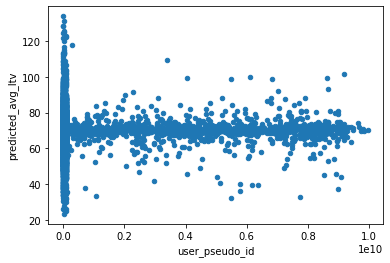

In [ ]:
df.plot('user_pseudo_id', 'predicted_avg_ltv', kind = 'scatter')